In [37]:
from pyspark.sql import functions as F
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [38]:
# Initialize Spark session
spark = SparkSession.builder.appName("logistic_regression").getOrCreate()

# Let's assume 'df' is your original DataFrame and 'isMoA' is your label column
biodata_all = spark.read.parquet("data/analysis/biodata_all_v2", header=True, inferSchema=True)

In [39]:
# Define a new column 'isGE_plus' based on the contents of 'sources'
biodata_GE_plus = biodata_all.withColumn(
    'isGE_plus',
    F.when((F.col('sources').isNull()) | (F.size(F.col('sources')) == 0), F.lit(False))
    .otherwise(F.lit(True))
)
biodata_GE_plus.show()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+---------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|isGE_plus|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+---

In [40]:
# Define the undesired lists as column expressions for comparison
undesired_chembl = F.array([F.lit('chembl')])
undesired_chemicalProbes = F.array([F.lit('chemicalProbes')])
undesired_both = F.array([F.lit('chembl'), F.lit('chemicalProbes')])
undesired_both_alt = F.array([F.lit('chemicalProbes'), F.lit('chembl')])

# Assuming biodata_all is your DataFrame
# Add the 'isGE' column
biodata_with_GE = biodata_GE_plus.withColumn(
    'isGE',
    ~(
        (F.col('sources').isNull()) |
        (F.size(F.col('sources')) == 0) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_chembl)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_chemicalProbes)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_both)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_both_alt))
    )
)
biodata_with_GE.show()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+---------+-----+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|isGE_plus| isGE|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+---------

In [55]:
pandas_df = biodata_with_GE.toPandas()

In [56]:
# Check the data types
print(pandas_df.dtypes)

# Convert booleans to integers
pandas_df['isMoA'] = pandas_df['isMoA'].astype(int)
pandas_df['isGE'] = pandas_df['isGE'].astype(int)
pandas_df['isGE_plus'] = pandas_df['isGE_plus'].astype(int)

accession               object
chembl_id               object
molregno                 int32
assay_chembl_id         object
src_id                   int32
src_short_name          object
journal                 object
pubmed_id              float64
doi                     object
tid                      int32
pref_name               object
target_chembl_id        object
organism                object
standard_value         float64
standard_units          object
standard_relation       object
pchembl_value          float64
targetID                object
isMoA                     bool
drugId                  object
uniprotId               object
sources                 object
isHighQualityProbe      object
isTherapeuticTarget     object
proteinClass            object
isActive                  bool
isGE_plus                 bool
isGE                      bool
dtype: object


In [57]:
# Splitting the dataset into train and test sets
train, test = train_test_split(pandas_df, test_size=0.2, random_state=42)  # 80% training and 20% testing

In [45]:
# Separate the independent variables and the dependent variable in the training set
X_train = train[['pchembl_value', 'isGE']]
y_train = train['isMoA']

In [46]:
# Add a constant to the independent variable set to represent the intercept
X_train = sm.add_constant(X_train)

In [47]:
# Building the logistic regression model
logit_model = sm.Logit(y_train, X_train)

In [48]:
# Fitting the model
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.254505
         Iterations 8


In [49]:
# Display the results
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  isMoA   No. Observations:                23766
Model:                          Logit   Df Residuals:                    23763
Method:                           MLE   Df Model:                            2
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.2455
Time:                        19:52:02   Log-Likelihood:                -6048.6
converged:                       True   LL-Null:                       -8017.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.9064      0.148    -60.322      0.000      -9.196      -8.617
pchembl_value     0.8264      0.018     46.312      0.000       0.791       0.861
isGE              1.7084      0.049     

In [52]:
import numpy as np

# Coefficients for pchembl_value
coef_pchembl_value = 0.8264
ci_lower_pchembl_value = 0.791
ci_upper_pchembl_value = 0.861

# Coefficients for isGE
coef_isGE = 1.7084
ci_lower_isGE = 1.613
ci_upper_isGE = 1.804

# Calculate Odds Ratios and their 95% Confidence Intervals
or_pchembl_value = np.exp(coef_pchembl_value)
or_ci_lower_pchembl_value = np.exp(ci_lower_pchembl_value)
or_ci_upper_pchembl_value = np.exp(ci_upper_pchembl_value)

or_isGE = np.exp(coef_isGE)
or_ci_lower_isGE = np.exp(ci_lower_isGE)
or_ci_upper_isGE = np.exp(ci_upper_isGE)

print("Odds Ratio for pchembl_value: {:.4f}".format(or_pchembl_value))
print("95% CI for pchembl_value: {:.4f}, {:.4f}".format(or_ci_lower_pchembl_value, or_ci_upper_pchembl_value))

print("Odds Ratio for isGE: {:.4f}".format(or_isGE))
print("95% CI for isGE: {:.4f}, {:.4f}".format(or_ci_lower_isGE, or_ci_upper_isGE))


Odds Ratio for pchembl_value: 2.2851
95% CI for pchembl_value: 2.2056, 2.3655
Odds Ratio for isGE: 5.5201
95% CI for isGE: 5.0178, 6.0739


In [50]:
# To get the Odds Ratio for 'isGE'
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
# Exponentiating the coefficients to get the odds ratios
print("Odds Ratio for isGE:")
print(np.exp(conf.loc['isGE']))

Odds Ratio for isGE:
2.5%     5.015818
97.5%    6.074615
OR       5.519888
Name: isGE, dtype: float64


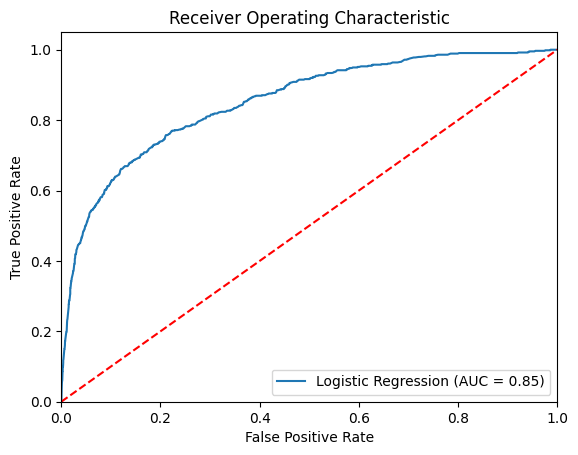

In [51]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Separate the independent variables and the dependent variable in the test set
X_test = test[['pchembl_value', 'isGE']]
y_test = test['isMoA']

# Add a constant to the independent variable set to represent the intercept
X_test = sm.add_constant(X_test)

# Making predictions on the test set (we need probability predictions for ROC)
y_pred_prob = result.predict(X_test)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')  # Dashed diagonal line representing a no-skill classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Run model for isGE_plus

In [59]:
# Separate the independent variables and the dependent variable in the training set
X_train = train[['pchembl_value', 'isGE_plus']]
y_train = train['isMoA']

In [60]:
# Add a constant to the independent variable set to represent the intercept
X_train = sm.add_constant(X_train)

In [61]:
# Building the logistic regression model
logit_model = sm.Logit(y_train, X_train)

In [62]:
# Fitting the model
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.248850
         Iterations 13


In [63]:
# Display the results
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  isMoA   No. Observations:                23766
Model:                          Logit   Df Residuals:                    23763
Method:                           MLE   Df Model:                            2
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.2623
Time:                        20:41:03   Log-Likelihood:                -5914.2
converged:                       True   LL-Null:                       -8017.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -12.2890      0.717    -17.134      0.000     -13.695     -10.883
pchembl_value     0.5873      0.017     34.092      0.000       0.554       0.621
isGE_plus         6.3684      0.708     

In [64]:
# To get the Odds Ratio for 'isGE_plus'
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
# Exponentiating the coefficients to get the odds ratios
print("Odds Ratio for isGE_plus:")
print(np.exp(conf.loc['isGE_plus']))

Odds Ratio for isGE_plus:
2.5%      145.635200
97.5%    2334.664476
OR        583.103187
Name: isGE_plus, dtype: float64


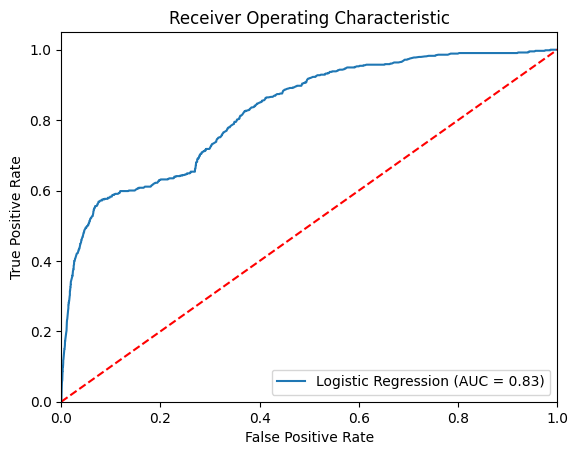

In [65]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Separate the independent variables and the dependent variable in the test set
X_test = test[['pchembl_value', 'isGE']]
y_test = test['isMoA']

# Add a constant to the independent variable set to represent the intercept
X_test = sm.add_constant(X_test)

# Making predictions on the test set (we need probability predictions for ROC)
y_pred_prob = result.predict(X_test)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')  # Dashed diagonal line representing a no-skill classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()